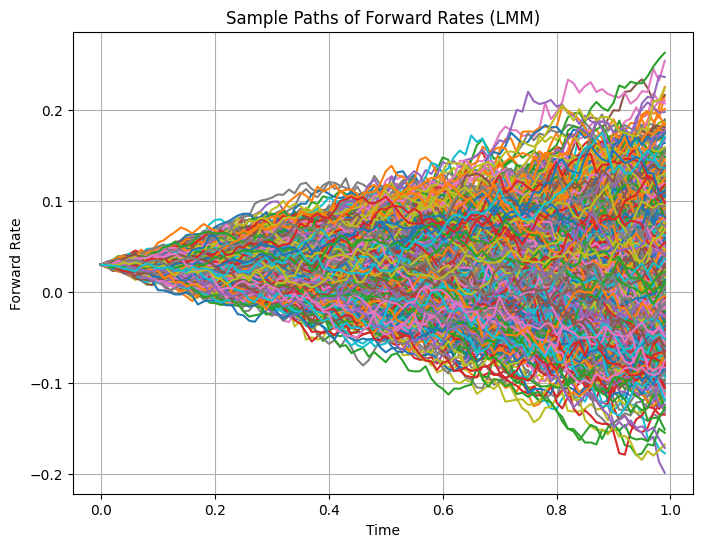

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_simulations = 1000
num_time_steps = 100
initial_forward_rate = 0.03
volatility = 0.01
time_increment = 0.01

# Initialize arrays
forward_rates = np.zeros((num_simulations, num_time_steps))
forward_rates[:, 0] = initial_forward_rate

# Generate random numbers
random_numbers = np.random.normal(0, 1, (num_simulations, num_time_steps))

# Simulate forward rates
for t in range(1, num_time_steps):
    drift = 0.5 * volatility**2 * t * time_increment
    diffusion = volatility * np.sqrt(t * time_increment) * random_numbers[:, t]
    forward_rates[:, t] = forward_rates[:, t - 1] + drift + diffusion

# Plot sample paths
plt.figure(figsize=(8, 6))
for i in range(num_simulations):
    plt.plot(np.arange(num_time_steps) * time_increment, forward_rates[i, :])

plt.xlabel("Time")
plt.ylabel("Forward Rate")
plt.title("Sample Paths of Forward Rates (LMM)")
plt.grid(True)
plt.show()


In [2]:
import numpy as np

def LIBOR_Market_Model(time_step, maturity, zero_curve, forward_rate_volatilities, N):
    steps = int(maturity / time_step) + 1
    t = np.linspace(0, maturity, steps)
    Delta = np.full(steps - 1, time_step)
    B_0 = 1 / (1 + zero_curve) ** t

    forward_rate_from_zero = np.diff(B_0) / Delta

    forward_rate_mc = np.zeros((N, steps - 1))
    for n in range(N):
        forward_rate = np.zeros((steps - 1, steps - 1))
        for i in range(steps - 1):
            forward_rate[i] = forward_rate_from_zero[i]
            for k in range(1, steps - 1):
                sum1 = 0
                for j in range(k):
                    sum2 = np.sum(forward_rate_volatilities[:, i - j - 1] * forward_rate_volatilities[:, k - j - 1])
                    sum3 = np.sum(forward_rate_volatilities[:, k - j - 1] ** 2)
                    sum4 = np.sum(forward_rate_volatilities[:, k - j - 1] * np.random.standard_normal() * np.sqrt(Delta[j]))
                    sum1 += (Delta[i] * forward_rate[i, j] * sum2) / (1 + Delta[i] * forward_rate[i, j])
                forward_rate[k, j + 1] = forward_rate[k, j] * np.exp((sum1 - sum3 / 2) * Delta[j] + sum4)

        forward_rate_mc[n] = forward_rate.sum(axis=1)

    return forward_rate_mc

# Example usage
time_step = 1
maturity = 10
zero_curve = np.array([0.0074, 0.0074, 0.0077, 0.0082, 0.0088, 0.0094, 0.0101, 0.0108, 0.0116, 0.0123, 0.0131])
forward_rate_volatilities = np.array([[0.1365, 0.1928, 0.1672, 0.1698, 0.1485, 0.1395, 0.1261, 0.1290, 0.1197, 0.1097],
                                      [-0.0662, -0.0702, -0.0406, -0.0206, 0, 0.0169, 0.0306, 0.0470, 0.0581, 0.0666],
                                      [0.0319, 0.0225, 0, -0.0198, -0.0347, -0.0163, 0, 0.0151, 0.0280, 0.0384]])

N_simulations = 1000
result = LIBOR_Market_Model(time_step, maturity, zero_curve, forward_rate_volatilities, N_simulations)
print(result)  # Matrix of forward rates for each simulation


[[-0.07345642 -0.07852039 -0.08966217 ... -0.15819498 -0.16225903
  -0.17819069]
 [-0.07345642 -0.07781229 -0.08860149 ... -0.15910795 -0.16007571
  -0.17779857]
 [-0.07345642 -0.07907738 -0.08937217 ... -0.1561588  -0.16164871
  -0.17517425]
 ...
 [-0.07345642 -0.07924755 -0.08963436 ... -0.1571965  -0.16235474
  -0.17822827]
 [-0.07345642 -0.07810526 -0.09179656 ... -0.15801147 -0.16116079
  -0.17618307]
 [-0.07345642 -0.0781001  -0.08977023 ... -0.15607005 -0.16155968
  -0.1775699 ]]


In [3]:
import numpy as np

def simulate_vasicek(r0, alpha, mu, sigma, T, dt):
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        dr = alpha * (mu - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr
    return rates

r0 = 0.01  # Initial short rate
alpha = 0.1  # Speed of mean reversion
mu = 0.05  # Long-term mean
sigma = 0.01  # Volatility
T = 1.0  # Time horizon
dt = 1/252  # Daily time step

short_rates = simulate_vasicek(r0, alpha, mu, sigma, T, dt)


In [4]:
def compute_money_market_account(rates, dt):
    B = np.exp(np.cumsum(rates * dt))
    return B

B = compute_money_market_account(short_rates, dt)


In [5]:
R_t0_tn = (B[-1] / B[0] - 1) / T


In [6]:
import numpy as np

class ShortRateModel:
    def __init__(self, r0, alpha, mu, sigma, dt):
        self.r0 = r0
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.dt = dt

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        rates = np.zeros((n_steps, n_sims))
        rates[0, :] = self.r0
        for t in range(1, n_steps):
            dr = self.alpha * (self.mu - rates[t-1, :]) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=n_sims)
            rates[t, :] = rates[t-1, :] + dr
        return rates


In [7]:
class MoneyMarketAccount:
    def __init__(self, short_rate_model):
        self.short_rate_model = short_rate_model

    def compute(self, short_rates):
        B = np.exp(np.cumsum(short_rates * self.short_rate_model.dt, axis=0))
        return B


In [8]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt):
        # Existing LMM initialization
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        # Short rate model
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        # Money market account
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt

    def simulate(self, T, n_sims):
        # Simulate short rates
        short_rates = self.short_rate_model.simulate(T, n_sims)
        # Compute money market account
        B = self.money_market_account.compute(short_rates)
        # Simulate forward rates using the existing LMM
        forward_rates = self.lmm.simulate_forward_rates()
        return forward_rates, short_rates, B


In [9]:
class LMM:
    # Existing methods...

    def simulate_forward_rates(self):
        # Existing simulation logic...
        pass

class ExtendedLMM(LMM):
    def simulate(self, T, n_sims):
        # Simulate short rates
        short_rates = self.short_rate_model.simulate(T, n_sims)
        # Compute money market account
        B = self.money_market_account.compute(short_rates)
        # Simulate forward rates using the existing LMM
        forward_rates = self.simulate_forward_rates()
        return forward_rates, short_rates, B


In [10]:
import numpy as np

def simulate_brownian_motion(d, n_steps, dt):
    return np.random.normal(0, np.sqrt(dt), (n_steps, d))


In [11]:
T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
M = len(T) - 1
tau = [T[k] - T[k-1] for k in range(1, len(T))]


In [12]:
def calculate_forward_libors(discount_factors, tau):
    L = [(discount_factors[k-1] / discount_factors[k] - 1) / tau[k-1] for k in range(1, len(discount_factors))]
    return L


In [13]:
def simulate_forward_libors(L0, sigma, W, tau, n_steps):
    L = np.zeros((n_steps, len(L0)))
    L[0, :] = L0
    for t in range(1, n_steps):
        for k in range(len(L0)):
            L[t, k] = L[t-1, k] + sigma[k](t, L[t-1, k]) * W[t, k]
    return L


In [14]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        W = simulate_brownian_motion(self.d, n_steps, self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        sigma = [lambda t, L: np.random.normal(0, 0.01) for _ in range(len(L0))]  # Example sigma functions
        forward_libors = simulate_forward_libors(L0, sigma, W, self.tau, n_steps)
        return forward_libors, short_rates, B


In [15]:
import numpy as np

# Example parameters
alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
d = len(alpha_k)  # Number of risk factors

# Define volatilities and correlations
def sigma_k(t, k):
    return np.array([0.02 + 0.01 * k * np.sin(t), 0.02 + 0.01 * k * np.cos(t)])

def v_k(t, k):
    return np.linalg.norm(sigma_k(t, k))

def rho_jk(t, j, k):
    sigma_j = sigma_k(t, j)
    sigma_k_val = sigma_k(t, k)
    return np.dot(sigma_j, sigma_k_val) / (v_k(t, j) * v_k(t, k))


In [16]:
def simulate_forward_libors(T, n_sims, dt, L0, alpha_k, v_k, rho_jk):
    n_steps = int(T / dt)
    M = len(L0)
    
    # Initialize Libor rates
    L = np.zeros((n_steps, M, n_sims))
    L[0, :, :] = L0[:, np.newaxis]
    
    # Simulate correlated Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            # Calculate drift and diffusion terms
            drift = 0
            diffusion = (L[t-1, k, :] + alpha_k[k]) * v_k(t*dt, k)
            for j in range(M):
                if j != k:
                    correlation = rho_jk(t*dt, j, k)
                    diffusion += correlation * (L[t-1, j, :] + alpha_k[j]) * v_k(t*dt, j)
            L[t, k, :] = L[t-1, k, :] + drift * dt + diffusion * W[t, k, :]
    
    return L


In [17]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = alpha_k

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_forward_libors(T, n_sims, self.dt, L0, self.alpha_k, v_k, rho_jk)
        return forward_libors, short_rates, B


In [18]:
def calculate_on_grid_discount_factors(L, tau, T, dt):
    n_steps, M, n_sims = L.shape
    P = np.ones((n_steps, M, n_sims))
    for t in range(1, n_steps):
        for i in range(1, M):
            P[t, i, :] = 1 / (1 + dt * L[t, i, :])
            for j in range(i + 1, M):
                P[t, j, :] *= 1 / (1 + tau[j-1] * L[t, j, :])
    return P


In [19]:
def calculate_off_grid_discount_factors(P, F, tau, T, dt):
    n_steps, M, n_sims = P.shape
    P_off_grid = np.ones((n_steps, M, n_sims))
    for t in range(1, n_steps):
        for i in range(1, M):
            P_off_grid[t, i, :] = 1 / (1 + dt * F[t, i, :])
            for j in range(i + 1, M):
                P_off_grid[t, j, :] *= 1 / (1 + tau[j-1] * F[t, j, :])
                if j == i + 1:
                    P_off_grid[t, j, :] *= (1 + dt * F[t, j, :])
    return P_off_grid


In [20]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = alpha_k

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_forward_libors(T, n_sims, self.dt, L0, self.alpha_k, v_k, rho_jk)
        on_grid_discount_factors = calculate_on_grid_discount_factors(forward_libors, self.tau, self.T, self.dt)
        off_grid_discount_factors = calculate_off_grid_discount_factors(on_grid_discount_factors, forward_rates, self.tau, self.T, self.dt)
        return forward_libors, short_rates, B, on_grid_discount_factors, off_grid_discount_factors


In [21]:
def calculate_mk(F0, L0, alpha_k, xi_k):
    return (F0 + xi_k) / (L0 + alpha_k)


In [22]:
def simulate_extended_grid_libors(T, n_sims, dt, L0, alpha_k, sigma_k):
    n_steps = int(T / dt)
    M = len(L0)
    
    # Initialize extended grid Libors
    L = np.zeros((n_steps, M, n_sims))
    L[0, :, :] = L0[:, np.newaxis]
    
    # Simulate Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            # Calculate drift and diffusion terms
            diffusion = (L[t-1, k, :] + alpha_k[k]) * sigma_k(t*dt, k)
            L[t, k, :] = L[t-1, k, :] + diffusion * W[t, k, :]
    
    return L


In [23]:
def simulate_forward_stub_rates(T, n_sims, dt, F0, L, alpha_k, xi_k, sigma_k):
    n_steps = int(T / dt)
    M = len(F0)
    
    # Initialize forward stub rates
    F = np.zeros((n_steps, M, n_sims))
    F[0, :, :] = F0[:, np.newaxis]
    
    # Calculate m_k(T)
    mk = calculate_mk(F0, L[0, :], alpha_k, xi_k)
    
    for t in range(1, n_steps):
        for k in range(M):
            # Calculate diffusion terms
            diffusion = mk[k] * (L[t-1, k, :] + alpha_k[k]) * sigma_k(t*dt, k)
            F[t, k, :] = F[t-1, k, :] + diffusion * np.random.normal(0, np.sqrt(dt), n_sims)
    
    return F


In [24]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = alpha_k
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_extended_grid_libors(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        forward_stub_rates = simulate_forward_stub_rates(T, n_sims, self.dt, forward_rates, forward_libors, self.alpha_k, self.xi_k, sigma_k)
        on_grid_discount_factors = calculate_on_grid_discount_factors(forward_libors, self.tau, self.T, self.dt)
        off_grid_discount_factors = calculate_off_grid_discount_factors(on_grid_discount_factors, forward_stub_rates, self.tau, self.T, self.dt)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors


In [25]:
def compute_extended_discount_factors(P, B, T, dt):
    n_steps, M, n_sims = P.shape
    P_extended = np.zeros((n_steps, M, n_sims))
    for t in range(n_steps):
        for k in range(M):
            if t * dt <= T[k]:
                P_extended[t, k, :] = P[t, k, :]
            else:
                P_extended[t, k, :] = B[t, :] / B[int(T[k] / dt), :]
    return P_extended


In [26]:
def calculate_fmm_rates(P_extended, B, T, tau, dt):
    n_steps, M, n_sims = P_extended.shape
    R = np.zeros((n_steps, M, n_sims))
    for t in range(n_steps):
        for k in range(M):
            if t * dt <= T[k-1]:
                R[t, k, :] = (1 / tau[k]) * (P_extended[t, k-1, :] / P_extended[t, k, :] - 1)
            elif T[k-1] <= t * dt <= T[k]:
                R[t, k, :] = (1 / tau[k]) * (B[t, :] * P_extended[t, k, :] / B[int(T[k-1] / dt), :] - 1)
            else:
                R[t, k, :] = (1 / tau[k]) * (B[int(T[k] / dt), :] / B[int(T[k-1] / dt), :] - 1)
    return R


In [27]:
def simulate_fmm_dynamics(R0, sigma_k, gamma_k, T, dt, n_sims):
    n_steps = int(T / dt)
    M = len(R0)
    
    # Initialize FMM rates
    R = np.zeros((n_steps, M, n_sims))
    R[0, :, :] = R0[:, np.newaxis]
    
    # Simulate Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            # Calculate drift and diffusion terms
            diffusion = gamma_k(t*dt) * sigma_k(t*dt, k) * W[t, k, :]
            R[t, k, :] = R[t-1, k, :] + diffusion
    return R


In [28]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = alpha_k
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_extended_grid_libors(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        forward_stub_rates = simulate_forward_stub_rates(T, n_sims, self.dt, forward_rates, forward_libors, self.alpha_k, self.xi_k, sigma_k)
        on_grid_discount_factors = calculate_on_grid_discount_factors(forward_libors, self.tau, self.T, self.dt)
        off_grid_discount_factors = calculate_off_grid_discount_factors(on_grid_discount_factors, forward_stub_rates, self.tau, self.T, self.dt)
        extended_discount_factors = compute_extended_discount_factors(on_grid_discount_factors, B, self.T, self.dt)
        fmm_rates = calculate_fmm_rates(extended_discount_factors, B, self.T, self.tau, self.dt)
        fmm_dynamics = simulate_fmm_dynamics(fmm_rates[0, :], sigma_k, gamma_k, T, self.dt, n_sims)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, fmm_rates, fmm_dynamics


In [29]:
def sigma_fmm(t, k, sigma_lmm):
    if t <= T[k-1]:
        return sigma_lmm(t, k)
    else:
        return sigma_lmm(T[k-1], k) * (1 - (t - T[k-1]) / (T[k] - T[k-1]))


In [30]:
def gamma_k(t, k, T):
    if t <= T[k-1]:
        return 1
    elif T[k-1] < t < T[k]:
        return 1 - (t - T[k-1]) / (T[k] - T[k-1])
    else:
        return 0


In [31]:
def simulate_fmm_dynamics(R0, sigma_lmm, T, dt, n_sims, gamma_k, sigma_fmm):
    n_steps = int(T / dt)
    M = len(R0)
    
    # Initialize FMM rates
    R = np.zeros((n_steps, M, n_sims))
    R[0, :, :] = R0[:, np.newaxis]
    
    # Simulate Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            gamma_t = gamma_k(t*dt, k, T)
            sigma_t = sigma_fmm(t*dt, k, sigma_lmm)
            diffusion = gamma_t * sigma_t * W[t, k, :]
            R[t, k, :] = R[t-1, k, :] + diffusion
    return R


In [32]:
def calculate_money_market_account(B, P, R, tau, T, dt):
    n_steps, M, n_sims = P.shape
    B_t = np.zeros((n_steps, n_sims))
    
    for t in range(n_steps):
        for k in range(M):
            if T[k-1] <= t * dt <= T[k]:
                B_t[t, :] = B[int(T[k-1] / dt), :] * P[t, k, :] * (1 + tau[k] * R[t, k, :])
            elif t * dt > T[k]:
                B_t[t, :] = B[int(T[k] / dt), :]
    return B_t


In [33]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(this.T))]
        self.alpha_k = alpha_k
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_extended_grid_libors(T, n_sims, self.dt, L0, self.alpha_k, sigma_lmm)
        forward_stub_rates = simulate_forward_stub_rates(T, n_sims, self.dt, forward_rates, forward_libors, self.alpha_k, self.xi_k, sigma_lmm)
        on_grid_discount_factors = calculate_on_grid_discount_factors(forward_libors, self.tau, self.T, self.dt)
        off_grid_discount_factors = calculate_off_grid_discount_factors(on_grid_discount_factors, forward_stub_rates, self.tau, self.T, self.dt)
        extended_discount_factors = compute_extended_discount_factors(on_grid_discount_factors, B, self.T, self.dt)
        fmm_rates = calculate_fmm_rates(extended_discount_factors, B, self.T, self.tau, self.dt)
        fmm_dynamics = simulate_fmm_dynamics(fmm_rates[0, :], sigma_lmm, T, self.dt, n_sims, gamma_k, sigma_fmm)
        money_market_account = calculate_money_market_account(B, extended_discount_factors, fmm_rates, self.tau, self.T, self.dt)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, fmm_rates, fmm_dynamics, money_market_account


In [34]:
def sigma_zombie(t, k, sigma_lmm):
    return sigma_lmm(min(t, T[k-1]), k)


In [35]:
def simulate_zombie_rates(T, n_sims, dt, L0, alpha_k, sigma_lmm):
    n_steps = int(T / dt)
    M = len(L0)
    
    # Initialize zombie rates
    L = np.zeros((n_steps, M, n_sims))
    L[0, :, :] = L0[:, np.newaxis]
    
    # Simulate Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            sigma_t = sigma_zombie(t*dt, k, sigma_lmm)
            diffusion = (L[t-1, k, :] + alpha_k[k]) * sigma_t * W[t, k, :]
            L[t, k, :] = L[t-1, k, :] + diffusion
    return L


In [36]:
def simulate_forward_stub_rates(T, n_sims, dt, F0, L, alpha_k, sigma_lmm):
    n_steps = int(T / dt)
    M = len(F0)
    
    # Initialize forward stub rates
    F = np.zeros((n_steps, M, n_sims))
    F[0, :, :] = F0[:, np.newaxis]
    
    for t in range(1, n_steps):
        for k in range(M):
            sigma_t = sigma_zombie(t*dt, k, sigma_lmm)
            diffusion = (F[t-1, k, :] + alpha_k[k]) * sigma_t * np.random.normal(0, np.sqrt(dt), n_sims)
            F[t, k, :] = F[t-1, k, :] + diffusion
    return F


In [37]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = alpha_k
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        zombie_libors = simulate_zombie_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_lmm)
        forward_stub_rates = simulate_forward_stub_rates(T, n_sims, self.dt, forward_rates, zombie_libors, self.alpha_k, sigma_lmm)
        on_grid_discount_factors = calculate_on_grid_discount_factors(zombie_libors, self.tau, self.T, self.dt)
        off_grid_discount_factors = calculate_off_grid_discount_factors(on_grid_discount_factors, forward_stub_rates, self.tau, self.T, self.dt)
        extended_discount_factors = compute_extended_discount_factors(on_grid_discount_factors, B, self.T, self.dt)
        fmm_rates =


SyntaxError: invalid syntax (1917153903.py, line 26)

In [38]:
def sigma_extension(t, k, sigma_k, T):
    if t <= T[k-1]:
        return sigma_k(t, k)
    else:
        return sigma_k(T[k-1], k)


In [39]:
def simulate_extended_grid_libors(T, n_sims, dt, L0, alpha_k, sigma_k):
    n_steps = int(T / dt)
    M = len(L0)
    
    # Initialize extended grid Libors
    L = np.zeros((n_steps, M, n_sims))
    L[0, :, :] = L0[:, np.newaxis]
    
    # Simulate Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            sigma_t = sigma_extension(t*dt, k, sigma_k, T)
            diffusion = (L[t-1, k, :] + alpha_k[k]) * sigma_t * W[t, k, :]
            L[t, k, :] = L[t-1, k, :] + diffusion
    return L


In [40]:
def simulate_forward_stub_rates(T, n_sims, dt, F0, L, alpha_k, sigma_k):
    n_steps = int(T / dt)
    M = len(F0)
    
    # Initialize forward stub rates
    F = np.zeros((n_steps, M, n_sims))
    F[0, :, :] = F0[:, np.newaxis]
    
    for t in range(1, n_steps):
        for k in range(M):
            sigma_t = sigma_extension(t*dt, k, sigma_k, T)
            diffusion = (F[t-1, k, :] + alpha_k[k]) * sigma_t * np.random.normal(0, np.sqrt(dt), n_sims)
            F[t, k, :] = F[t-1, k, :] + diffusion
    return F


In [41]:
def calculate_money_market_account(B, P, R, tau, T, dt):
    n_steps, M, n_sims = P.shape
    B_t = np.zeros((n_steps, n_sims))
    
    for t in range(n_steps):
        for k in range(M):
            if T[k-1] <= t * dt <= T[k]:
                B_t[t, :] = B[int(T[k-1] / dt), :] * P[t, k, :] * (1 + tau[k] * R[t, k, :])
            elif t * dt > T[k]:
                B_t[t, :] = B[int(T[k] / dt), :]
    return B_t


In [42]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = alpha_k
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_extended_grid_libors(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        forward_stub_rates = simulate_forward_stub_rates(T, n_sims, self.dt, forward_rates, forward_libors, self.alpha_k, sigma_k)
        on_grid_discount_factors = calculate_on_grid_discount_factors(forward_libors, self.tau, self.T, self.dt)
        off_grid_discount_factors = calculate_off_grid_discount_factors(on_grid_discount_factors, forward_stub_rates, self.tau, self.T, self.dt)
        extended_discount_factors = compute_extended_discount_factors(on_grid_discount_factors, B, self.T, self.dt)
        fmm_rates = calculate_fmm_rates(extended_discount_factors, B, self.T, self.tau, self.dt)
        money_market_account = calculate_money_market_account(B, extended_discount_factors, fmm_rates, self.tau, self.T, self.dt)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, fmm_rates, money_market_account


In [43]:
def calculate_short_term_rate(F_t, alpha_k, T_k):
    return F_t + alpha_k


In [44]:
def simulate_money_market_account(T, n_sims, dt, F, alpha_k, T_grid):
    n_steps = int(T / dt)
    B = np.ones((n_steps, n_sims))
    r = np.zeros((n_steps, n_sims))
    
    for t in range(1, n_steps):
        for k in range(len(T_grid) - 1):
            if T_grid[k] <= t * dt < T_grid[k+1]:
                F_t = F[t, k, :]
                r_t = calculate_short_term_rate(F_t, alpha_k[k], T_grid[k])
                r[t, :] = r_t
                B[t, :] = B[t-1, :] * np.exp(r_t * dt)
    return B, r


In [45]:
def calculate_compounded_in_arrears_RFR(B, T_start, T_end, dt):
    B_start = B[int(T_start / dt), :]
    B_end = B[int(T_end / dt), :]
    delta = T_end - T_start
    R = (B_end / B_start - 1) / delta
    return R


In [46]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_extended_grid_libors(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        forward_stub_rates = simulate_forward_stub_rates(T, n_sims, self.dt, forward_rates, forward_libors, self.alpha_k, sigma_k)
        on_grid_discount_factors = calculate_on_grid_discount_factors(forward_libors, self.tau, self.T, self.dt)
        off_grid_discount_factors = calculate_off_grid_discount_factors(on_grid_discount_factors, forward_stub_rates, self.tau, self.T, self.dt)
        extended_discount_factors = compute_extended_discount_factors(on_grid_discount_factors, B, self.T, self.dt)
        fmm_rates = calculate_fmm_rates(extended_discount_factors, B, self.T, self.tau, self.dt)
        B_simulated, r_simulated = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_simulated, 0.5, 1.0, self.dt)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, fmm_rates, B_simulated, compounded_RFR


In [47]:
def calculate_basis(F_proj_0, F_disc_0):
    return F_proj_0 - F_disc_0


In [48]:
def simulate_discount_forward_rates(T, n_sims, dt, L0, alpha_k, sigma_k):
    n_steps = int(T / dt)
    M = len(L0)
    
    # Initialize forward rates
    L = np.zeros((n_steps, M, n_sims))
    L[0, :, :] = L0[:, np.newaxis]
    
    # Simulate Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            sigma_t = sigma_extension(t * dt, k, sigma_k, T)
            diffusion = (L[t-1, k, :] + alpha_k[k]) * sigma_t * W[t, k, :]
            L[t, k, :] = L[t-1, k, :] + diffusion
    return L


In [49]:
def simulate_money_market_account(T, n_sims, dt, F, alpha_k, T_grid):
    n_steps = int(T / dt)
    B_disc = np.ones((n_steps, n_sims))
    B_proj = np.ones((n_steps, n_sims))
    r_disc = np.zeros((n_steps, n_sims))
    lambda_t = np.zeros(n_steps)
    
    for t in range(1, n_steps):
        for k in range(len(T_grid) - 1):
            if T_grid[k] <= t * dt < T_grid[k+1]:
                F_t = F[t, k, :]
                r_t = calculate_short_term_rate(F_t, alpha_k[k], T_grid[k])
                r_disc[t, :] = r_t
                B_disc[t, :] = B_disc[t-1, :] * np.exp(r_t * dt)
                
                lambda_t[t] = P_disc[0, t] / P_proj[0, t]
                B_proj[t, :] = lambda_t[t] * B_disc[t, :]
    return B_disc, B_proj, r_disc


In [50]:
def calculate_compounded_in_arrears_RFR(B_proj, T_start, T_end, dt):
    B_start = B_proj[int(T_start / dt), :]
    B_end = B_proj[int(T_end / dt), :]
    delta = T_end - T_start
    R = (B_end / B_start - 1) / delta
    return R


In [51]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_discount_forward_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        basis = calculate_basis(F_proj_0, F_disc_0)
        F_proj = forward_libors + basis[:, np.newaxis, np.newaxis]
        B_disc, B_proj, r_disc = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_proj, 0.5, 1.0, self.dt)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, F_proj, B_disc, B_proj, compounded_RFR


In [52]:
def price_swaption(A_ab, S_ab, alpha_ab, V_ab, K):
    return A_ab * black(S_ab + alpha_ab, K + alpha_ab, np.sqrt(V_ab))


In [53]:
def price_forward_caplet(P_k, L_k, alpha_k, V_k, K, tau_k):
    return tau_k * P_k * black(L_k + alpha_k, K + alpha_k, np.sqrt(V_k))

def calibrate_backward_caplet_volatility(L_k, sigma_k, T_grid):
    # Implement calibration logic here
    pass


In [54]:
def simulate_zombie_rate_and_volatility(T, n_sims, dt, L0, alpha_k, sigma_k, T_grid):
    n_steps = int(T / dt)
    M = len(L0)
    
    # Initialize zombie rates and volatilities
    L_zombie = np.zeros((n_steps, M, n_sims))
    L_zombie[0, :, :] = L0[:, np.newaxis]
    sigma_zombie = np.zeros((n_steps, M, n_sims))
    
    # Simulate Brownian motions
    W = np.random.normal(0, np.sqrt(dt), (n_steps, M, n_sims))
    
    for t in range(1, n_steps):
        for k in range(M):
            sigma_t = sigma_extension(t * dt, k, sigma_k, T_grid)
            diffusion = (L_zombie[t-1, k, :] + alpha_k[k]) * sigma_t * W[t, k, :]
            L_zombie[t, k, :] = L_zombie[t-1, k, :] + diffusion
            sigma_zombie[t, k, :] = sigma_t
    return L_zombie, sigma_zombie


In [55]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_discount_forward_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        basis = calculate_basis(F_proj_0, F_disc_0)
        F_proj = forward_libors + basis[:, np.newaxis, np.newaxis]
        B_disc, B_proj, r_disc = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        L_zombie, sigma_zombie = simulate_zombie_rate_and_volatility(T, n_sims, self.dt, L0, self.alpha_k, sigma_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_proj, 0.5, 1.0, self.dt)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, F_proj, B_disc, B_proj, compounded_RFR, L_zombie, sigma_zombie


In [56]:
from scipy.optimize import fsolve

def bachelier_call_price(F, K, sigma, T):
    d1 = (F - K) / (sigma * np.sqrt(T))
    return sigma * np.sqrt(T) * (d1 * norm.cdf(d1) + norm.pdf(d1))

def implied_forward_volatility(c_back, L0, K, tau_k, T_km1):
    def objective(sigma_fwd):
        return c_back - tau_k * bachelier_call_price(L0, K, sigma_fwd, T_km1 + tau_k / 3)
    
    sigma_fwd_initial_guess = 0.01
    sigma_fwd = fsolve(objective, sigma_fwd_initial_guess)[0]
    return sigma_fwd


In [57]:
def synthetic_forward_caplet_premium(L0, K, sigma_fwd, tau_k, T_km1):
    return tau_k * bachelier_call_price(L0, K, sigma_fwd, T_km1)


In [58]:
def black_call_price(F, K, sigma, T):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return F * norm.cdf(d1) - K * norm.cdf(d2)

def zombie_rate_volatility(c_fwd, L0, K, alpha_k, tau_k, T_km1):
    def objective(sigma_kk):
        F_shifted = L0 + alpha_k
        K_shifted = K + alpha_k
        return c_fwd - tau_k * black_call_price(F_shifted, K_shifted, sigma_kk, T_km1)
    
    sigma_kk_initial_guess = 0.01
    sigma_kk = fsolve(objective, sigma_kk_initial_guess)[0]
    return sigma_kk


In [59]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def calibrate_to_rfr_caplets(self, caplet_pvs, strikes):
        implied_forward_vols = []
        zombie_rate_vols = []

        for i, c_back in enumerate(caplet_pvs):
            K = strikes[i]
            tau_k = self.tau[i]
            T_km1 = self.T[i]
            L0 = self.lmm.forward_rates[0, i, 0]

            # Step 1: Calculate implied forward volatility
            sigma_fwd = implied_forward_volatility(c_back, L0, K, tau_k, T_km1)
            implied_forward_vols.append(sigma_fwd)

            # Step 2: Calculate synthetic forward-looking caplet premium
            c_fwd = synthetic_forward_caplet_premium(L0, K, sigma_fwd, tau_k, T_km1)

            # Step 3: Convert to zombie rate volatility
            sigma_kk = zombie_rate_volatility(c_fwd, L0, K, self.alpha_k[i], tau_k, T_km1)
            zombie_rate_vols.append(sigma_kk)

        self.implied_forward_vols = np.array(implied_forward_vols)
        self.zombie_rate_vols = np.array(zombie_rate_vols)

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_discount_forward_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        basis = calculate_basis(F_proj_0, F_disc_0)
        F_proj = forward_libors + basis[:, np.newaxis, np.newaxis]
        B_disc, B_proj, r_disc = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        L_zombie, sigma_zombie = simulate_zombie_rate_and_volatility(T, n_sims, self.dt, L0, self.alpha_k, sigma_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_proj, 0.5, 1.0, self.dt)
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, F_proj, B_disc, B_proj, compounded_RFR, L_zombie, sigma_zombie


In [60]:
def geometric_compounding(rates):
    return np.prod(1 + rates) ** (1 / len(rates)) - 1

def simple_averaging(rates):
    return np.mean(rates)

def calculate_rfr_average(rates, method='geometric'):
    if method == 'geometric':
        return geometric_compounding(rates)
    elif method == 'simple':
        return simple_averaging(rates)
    else:
        raise ValueError("Unsupported method. Use 'geometric' or 'simple'.")


In [61]:
def fetch_term_sofr_rate(tenor, date):
    # Placeholder for fetching Term SOFR rate from CME or other source
    term_sofr_rates = {
        '1M': 0.0015,
        '3M': 0.0020,
        '6M': 0.0025,
        '12M': 0.0030
    }
    return term_sofr_rates.get(tenor, 0.0020)


In [62]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def calculate_rfr(self, rates, method='geometric'):
        return calculate_rfr_average(rates, method)

    def fetch_term_sofr(self, tenor, date):
        return fetch_term_sofr_rate(tenor, date)

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_discount_forward_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        basis = calculate_basis(F_proj_0, F_disc_0)
        F_proj = forward_libors + basis[:, np.newaxis, np.newaxis]
        B_disc, B_proj, r_disc = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        L_zombie, sigma_zombie = simulate_zombie_rate_and_volatility(T, n_sims, self.dt, L0, self.alpha_k, sigma_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_proj, 0.5, 1.0, self.dt)
        
        # Example usage of Term SOFR rate
        term_sofr_3m = self.fetch_term_sofr('3M', '2023-01-01')
        
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, F_proj, B_disc, B_proj, compounded_RFR, L_zombie, sigma_zombie, term_sofr_3m


In [63]:
def calculate_term_sofr_basis(F_term_sofr_0, F_sofr_0):
    return F_term_sofr_0 - F_sofr_0

def forward_term_sofr_rate(F_sofr_t, beta_term_sofr_sofr):
    return F_sofr_t + beta_term_sofr_sofr


In [64]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def calculate_rfr(self, rates, method='geometric'):
        return calculate_rfr_average(rates, method)

    def fetch_term_sofr(self, tenor, date):
        return fetch_term_sofr_rate(tenor, date)

    def calculate_term_sofr_rate(self, F_sofr_t, tenor, date):
        F_term_sofr_0 = self.fetch_term_sofr(tenor, date)
        F_sofr_0 = F_sofr_t
        beta_term_sofr_sofr = calculate_term_sofr_basis(F_term_sofr_0, F_sofr_0)
        return forward_term_sofr_rate(F_sofr_t, beta_term_sofr_sofr)

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_discount_forward_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        basis = calculate_basis(F_proj_0, F_disc_0)
        F_proj = forward_libors + basis[:, np.newaxis, np.newaxis]
        B_disc, B_proj, r_disc = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        L_zombie, sigma_zombie = simulate_zombie_rate_and_volatility(T, n_sims, self.dt, L0, self.alpha_k, sigma_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_proj, 0.5, 1.0, self.dt)
        
        # Example usage of Term SOFR rate
        term_sofr_3m = self.calculate_term_sofr_rate(forward_rates[0, 1, :], '3M', '2023-01-01')
        
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, F_proj, B_disc, B_proj, compounded_RFR, L_zombie, sigma_zombie, term_sofr_3m


In [65]:
def term_sofr_coupon(fixing_value, floor, cap):
    return max(floor, min(cap, fixing_value))


In [66]:
def calibrate_to_sofr_instruments(self, swaption_data, caplet_data):
    # Example placeholder functions for calibration
    def calibrate_swaptions(swaption_data):
        # Perform calibration using swaption data
        pass
    
    def calibrate_caplets(caplet_data):
        # Perform calibration using caplet data
        pass

    calibrate_swaptions(swaption_data)
    calibrate_caplets(caplet_data)


In [67]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def calculate_term_sofr_rate(self, F_sofr_t, tenor, date):
        F_term_sofr_0 = self.fetch_term_sofr(tenor, date)
        F_sofr_0 = F_sofr_t
        beta_term_sofr_sofr = calculate_term_sofr_basis(F_term_sofr_0, F_sofr_0)
        return forward_term_sofr_rate(F_sofr_t, beta_term_sofr_sofr)

    def calibrate_to_sofr_instruments(self, swaption_data, caplet_data):
        # Calibrate to vanilla SOFR swaptions and backward-looking SOFR caplets
        self.calibrate_swaptions(swaption_data)
        self.calibrate_caplets(caplet_data)

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_discount_forward_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        basis = calculate_basis(F_proj_0, F_disc_0)
        F_proj = forward_libors + basis[:, np.newaxis, np.newaxis]
        B_disc, B_proj, r_disc = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        L_zombie, sigma_zombie = simulate_zombie_rate_and_volatility(T, n_sims, self.dt, L0, self.alpha_k, sigma_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_proj, 0.5, 1.0, self.dt)
        
        # Example usage of Term SOFR rate
        term_sofr_3m = self.calculate_term_sofr_rate(forward_rates[0, 1, :], '3M', '2023-01-01')
        
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, F_proj, B_disc, B_proj, compounded_RFR, L_zombie, sigma_zombie, term_sofr_3m


In [68]:
def term_sofr_coupon(fixing_value, floor, cap):
    return max(floor, min(cap, fixing_value))


In [69]:
def monte_carlo_sofr_swap_pricing(T, n_sims, dt, forward_rates, discount_factors):
    n_steps = int(T / dt)
    par_rates = []

    for _ in range(n_sims):
        B = np.ones(n_steps)
        for t in range(1, n_steps):
            B[t] = B[t-1] * np.exp(forward_rates[t-1] * dt)

        swap_value = np.sum(B * discount_factors * dt)
        par_rate = 1.0 / swap_value  # Simplified for example; actual calculation may vary
        par_rates.append(par_rate)

    return np.mean(par_rates)

def sofr_vs_libor_basis_swap_pricing(T, n_sims, dt, sofr_forward_rates, libor_forward_rates, discount_factors):
    n_steps = int(T / dt)
    par_spreads = []

    for _ in range(n_sims):
        B_sofr = np.ones(n_steps)
        B_libor = np.ones(n_steps)
        for t in range(1, n_steps):
            B_sofr[t] = B_sofr[t-1] * np.exp(sofr_forward_rates[t-1] * dt)
            B_libor[t] = B_libor[t-1] * np.exp(libor_forward_rates[t-1] * dt)

        swap_value_sofr = np.sum(B_sofr * discount_factors * dt)
        swap_value_libor = np.sum(B_libor * discount_factors * dt)
        par_spread = (swap_value_libor - swap_value_sofr) / T  # Simplified; actual calculation may vary
        par_spreads.append(par_spread)

    return np.mean(par_spreads)


In [70]:
def analytic_sofr_swap_pricing(discount_factors, forward_rates):
    swap_value = np.sum(discount_factors * forward_rates)
    par_rate = 1.0 / swap_value  # Simplified; actual calculation may vary
    return par_rate

def sofr_vs_libor_analytic_pricing(discount_factors, sofr_forward_rates, libor_forward_rates):
    swap_value_sofr = np.sum(discount_factors * sofr_forward_rates)
    swap_value_libor = np.sum(discount_factors * libor_forward_rates)
    par_spread = (swap_value_libor - swap_value_sofr) / len(sofr_forward_rates)  # Simplified; actual calculation may vary
    return par_spread


In [71]:
def run_comparisons(T, n_sims, dt, forward_rates, sofr_forward_rates, libor_forward_rates, discount_factors):
    # SLMM Monte Carlo Pricing
    slmm_par_rate = monte_carlo_sofr_swap_pricing(T, n_sims, dt, forward_rates, discount_factors)
    slmm_par_spread = sofr_vs_libor_basis_swap_pricing(T, n_sims, dt, sofr_forward_rates, libor_forward_rates, discount_factors)

    # SWPM Analytic Pricing
    swpm_par_rate = analytic_sofr_swap_pricing(discount_factors, forward_rates)
    swpm_par_spread = sofr_vs_libor_analytic_pricing(discount_factors, sofr_forward_rates, libor_forward_rates)

    print(f"SLMM Par Rate: {slmm_par_rate}, SWPM Par Rate: {swpm_par_rate}")
    print(f"SLMM Par Spread: {slmm_par_spread}, SWPM Par Spread: {swpm_par_spread}")

    return slmm_par_rate, swpm_par_rate, slmm_par_spread, swpm_par_spread

# Example parameters (these would be fetched or computed from market data in a real implementation)
T = 1.0  # 1 year
n_sims = 1000
dt = 1/252  # Daily steps
forward_rates = np.random.normal(0.02, 0.001, int(T / dt))  # Simplified example forward rates
sofr_forward_rates = np.random.normal(0.015, 0.001, int(T / dt))
libor_forward_rates = np.random.normal(0.025, 0.001, int(T / dt))
discount_factors = np.exp(-0.02 * np.arange(0, T, dt))  # Simplified example discount factors

run_comparisons(T, n_sims, dt, forward_rates, sofr_forward_rates, libor_forward_rates, discount_factors)


SLMM Par Rate: 1.0000225773707674, SWPM Par Rate: 0.20048462662139702
SLMM Par Spread: 0.004967357204396894, SWPM Par Spread: 0.009893373490230416


(np.float64(1.0000225773707674),
 np.float64(0.20048462662139702),
 np.float64(0.004967357204396894),
 np.float64(0.009893373490230416))

In [72]:
from scipy.stats import norm

def bachelier_call_price(F, K, sigma, T):
    d1 = (F - K) / (sigma * np.sqrt(T))
    return sigma * np.sqrt(T) * (d1 * norm.cdf(d1) + norm.pdf(d1))

def implied_volatility_bachelier(price, F, K, T):
    def objective(sigma):
        return price - bachelier_call_price(F, K, sigma, T)
    
    vol_initial_guess = 0.01
    implied_vol = fsolve(objective, vol_initial_guess)[0]
    return implied_vol

def monte_carlo_rfr_caplet_pricing(T, n_sims, dt, forward_rates, discount_factors, strike):
    n_steps = int(T / dt)
    caplet_prices = []

    for _ in range(n_sims):
        B = np.ones(n_steps)
        for t in range(1, n_steps):
            B[t] = B[t-1] * np.exp(forward_rates[t-1] * dt)

        payoff = np.maximum(B[-1] - strike, 0)
        caplet_price = np.mean(payoff * discount_factors)
        caplet_prices.append(caplet_price)

    return np.mean(caplet_prices)

def monte_carlo_forward_looking_caplet_pricing(T, n_sims, dt, forward_rates, discount_factors, strike):
    n_steps = int(T / dt)
    caplet_prices = []

    for _ in range(n_sims):
        F = forward_rates[-1]  # Assuming forward rate at maturity
        payoff = np.maximum(F - strike, 0)
        caplet_price = np.mean(payoff * discount_factors)
        caplet_prices.append(caplet_price)

    return np.mean(caplet_prices)


In [73]:
def run_caplet_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike):
    # Monte Carlo Pricing
    rfr_caplet_price = monte_carlo_rfr_caplet_pricing(T, n_sims, dt, forward_rates, discount_factors, strike)
    forward_looking_caplet_price = monte_carlo_forward_looking_caplet_pricing(T, n_sims, dt, forward_rates, discount_factors, strike)

    # Implied Volatilities
    implied_vol_rfr = implied_volatility_bachelier(rfr_caplet_price, forward_rates[-1], strike, T)
    implied_vol_forward = implied_volatility_bachelier(forward_looking_caplet_price, forward_rates[-1], strike, T)

    print(f"RFR Caplet Price: {rfr_caplet_price}, Implied Volatility: {implied_vol_rfr}")
    print(f"Forward-Looking Caplet Price: {forward_looking_caplet_price}, Implied Volatility: {implied_vol_forward}")

    return rfr_caplet_price, implied_vol_rfr, forward_looking_caplet_price, implied_vol_forward

# Example parameters (these would be fetched or computed from market data in a real implementation)
T = 1.0  # 1 year
n_sims = 1000
dt = 1/252  # Daily steps
forward_rates = np.random.normal(0.02, 0.001, int(T / dt))  # Simplified example forward rates
discount_factors = np.exp(-0.02 * np.arange(0, T, dt))  # Simplified example discount factors
strike = 0.02  # Example strike rate

run_caplet_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike)


RFR Caplet Price: 0.9902008732687066, Implied Volatility: 2.4799996479262476
Forward-Looking Caplet Price: 0.001631575090031385, Implied Volatility: 9.015138831541277e-05


C:\Users\tanishk.deoghare\AppData\Local\Temp\ipykernel_9700\2184040106.py:12: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  implied_vol = fsolve(objective, vol_initial_guess)[0]


(np.float64(0.9902008732687066),
 np.float64(2.4799996479262476),
 np.float64(0.001631575090031385),
 np.float64(9.015138831541277e-05))

In [74]:
def monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry):
    n_steps = int(T / dt)
    swaption_prices = []

    for _ in range(n_sims):
        B = np.ones(n_steps)
        for t in range(1, n_steps):
            B[t] = B[t-1] * np.exp(forward_rates[t-1] * dt)
        
        payoff = np.maximum(B[-1] - strike, 0) if n_steps * dt >= expiry else 0
        swaption_price = np.mean(payoff * discount_factors)
        swaption_prices.append(swaption_price)

    return np.mean(swaption_prices)

def monte_carlo_forward_looking_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry):
    n_steps = int(T / dt)
    swaption_prices = []

    for _ in range(n_sims):
        F = forward_rates[int(expiry / dt)]  # Assuming forward rate at expiry
        payoff = np.maximum(F - strike, 0) if n_steps * dt >= expiry else 0
        swaption_price = np.mean(payoff * discount_factors)
        swaption_prices.append(swaption_price)

    return np.mean(swaption_prices)


In [75]:
def run_swaption_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry):
    # Monte Carlo Pricing
    rfr_swaption_price = monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry)
    forward_looking_swaption_price = monte_carlo_forward_looking_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry)

    print(f"RFR Swaption Price: {rfr_swaption_price}")
    print(f"Forward-Looking Swaption Price: {forward_looking_swaption_price}")

    return rfr_swaption_price, forward_looking_swaption_price

# Example parameters (these would be fetched or computed from market data in a real implementation)
T = 1.0  # 1 year
n_sims = 1000
dt = 1/252  # Daily steps
forward_rates = np.random.normal(0.02, 0.001, int(T / dt))  # Simplified example forward rates
discount_factors = np.exp(-0.02 * np.arange(0, T, dt))  # Simplified example discount factors
strike = 0.02  # Example strike rate
expiry = 0.5  # 6 months

run_swaption_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry)


RFR Swaption Price: 0.9901533155081151
Forward-Looking Swaption Price: 0.0012176495761130894


(np.float64(0.9901533155081151), np.float64(0.0012176495761130894))

In [76]:
import numpy as np
from scipy.optimize import fsolve

def bachelier_call_price(F, K, sigma, T):
    d1 = (F - K) / (sigma * np.sqrt(T))
    return sigma * np.sqrt(T) * (d1 * norm.cdf(d1) + norm.pdf(d1))

def monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier):
    n_steps = int(T / dt)
    swaption_prices = []

    for _ in range(n_sims):
        B = np.ones(n_steps)
        for t in range(1, n_steps):
            bumped_vol = forward_rates[t-1] * vol_multiplier
            B[t] = B[t-1] * np.exp(bumped_vol * dt)
        
        payoff = np.maximum(B[-1] - strike, 0) if n_steps * dt >= expiry else 0
        swaption_price = np.mean(payoff * discount_factors)
        swaption_prices.append(swaption_price)

    return np.mean(swaption_prices)

def monte_carlo_forward_looking_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier):
    n_steps = int(T / dt)
    swaption_prices = []

    for _ in range(n_sims):
        bumped_vol = forward_rates[int(expiry / dt)] * vol_multiplier
        F = forward_rates[int(expiry / dt)]
        payoff = np.maximum(F - strike, 0) if n_steps * dt >= expiry else 0
        swaption_price = np.mean(payoff * discount_factors)
        swaption_prices.append(swaption_price)

    return np.mean(swaption_prices)


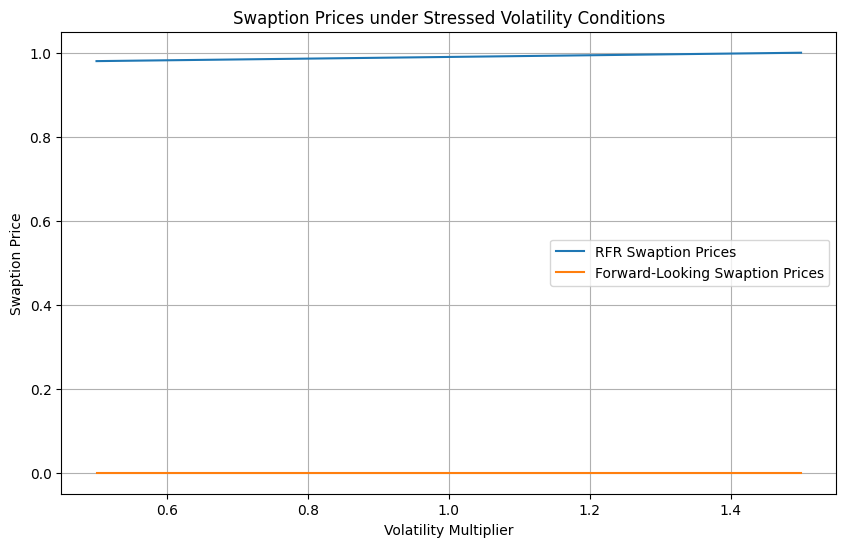

In [77]:
def run_stressed_volatility_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry):
    vol_multipliers = np.linspace(0.5, 1.5, 11)  # From -50% to +50% bumps
    rfr_prices = []
    forward_looking_prices = []

    for vol_multiplier in vol_multipliers:
        rfr_price = monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier)
        forward_price = monte_carlo_forward_looking_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier)
        rfr_prices.append(rfr_price)
        forward_looking_prices.append(forward_price)
    
    return vol_multipliers, rfr_prices, forward_looking_prices

# Example parameters (these would be fetched or computed from market data in a real implementation)
T = 1.0  # 1 year
n_sims = 1000
dt = 1/252  # Daily steps
forward_rates = np.random.normal(0.02, 0.001, int(T / dt))  # Simplified example forward rates
discount_factors = np.exp(-0.02 * np.arange(0, T, dt))  # Simplified example discount factors
strike = 0.02  # Example strike rate
expiry = 0.5  # 6 months

vol_multipliers, rfr_prices, forward_looking_prices = run_stressed_volatility_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vol_multipliers, rfr_prices, label='RFR Swaption Prices')
plt.plot(vol_multipliers, forward_looking_prices, label='Forward-Looking Swaption Prices')
plt.xlabel('Volatility Multiplier')
plt.ylabel('Swaption Price')
plt.title('Swaption Prices under Stressed Volatility Conditions')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
def calculate_compounded_rfr(rates, accrual_period):
    compounded_rate = np.prod(1 + rates) ** (1 / len(rates)) - 1
    return compounded_rate * accrual_period


In [79]:
def apply_ibor_fallback(rfr_rates, isda_spread, accrual_period):
    compounded_rfr = calculate_compounded_rfr(rfr_rates, accrual_period)
    fallback_rate = compounded_rfr + isda_spread
    return fallback_rate


In [80]:
class ExtendedLMM:
    def __init__(self, swaption_vol_matrix_path, swap_curve_path, short_rate_params, dt, d):
        self.lmm = LMM(swaption_vol_matrix_path, swap_curve_path)
        self.short_rate_model = ShortRateModel(*short_rate_params, dt)
        self.money_market_account = MoneyMarketAccount(self.short_rate_model)
        self.dt = dt
        self.d = d
        self.T = [0, 0.5, 1.0, 1.5, 2.0]  # Example grid points
        self.M = len(self.T) - 1
        self.tau = [self.T[k] - self.T[k-1] for k in range(1, len(self.T))]
        self.alpha_k = np.array([0.01, 0.015, 0.02])  # Example shifts
        self.xi_k = np.array([0.001, 0.0015, 0.002])  # Example stub-specific shifts

    def calculate_compounded_rfr(self, rates, accrual_period):
        return calculate_compounded_rfr(rates, accrual_period)

    def apply_ibor_fallback(self, rfr_rates, isda_spread, accrual_period):
        return apply_ibor_fallback(rfr_rates, isda_spread, accrual_period)

    def price_legacy_deal_with_fallback(self, T, n_sims, dt, forward_rates, discount_factors, strike, expiry, isda_spread, accrual_period):
        # Apply IBOR fallback methodology
        fallback_rate = self.apply_ibor_fallback(forward_rates, isda_spread, accrual_period)
        
        # Price the deal using the fallback rate
        n_steps = int(T / dt)
        swaption_prices = []
        
        for _ in range(n_sims):
            B = np.ones(n_steps)
            for t in range(1, n_steps):
                B[t] = B[t-1] * np.exp(forward_rates[t-1] * dt)
            
            payoff = np.maximum(B[-1] - fallback_rate, 0) if n_steps * dt >= expiry else 0
            swaption_price = np.mean(payoff * discount_factors)
            swaption_prices.append(swaption_price)

        return np.mean(swaption_prices)

    def simulate(self, T, n_sims):
        n_steps = int(T / self.dt)
        short_rates = self.short_rate_model.simulate(T, n_sims)
        B = self.money_market_account.compute(short_rates)
        forward_rates = self.lmm.simulate_forward_rates()
        initial_discount_factors = np.exp(-np.cumsum(short_rates[0, :] * self.dt))
        L0 = calculate_forward_libors(initial_discount_factors, self.tau)
        forward_libors = simulate_discount_forward_rates(T, n_sims, self.dt, L0, self.alpha_k, sigma_k)
        basis = calculate_basis(F_proj_0, F_disc_0)
        F_proj = forward_libors + basis[:, np.newaxis, np.newaxis]
        B_disc, B_proj, r_disc = simulate_money_market_account(T, n_sims, self.dt, forward_rates, self.alpha_k, self.T)
        L_zombie, sigma_zombie = simulate_zombie_rate_and_volatility(T, n_sims, self.dt, L0, self.alpha_k, sigma_k, self.T)
        compounded_RFR = calculate_compounded_in_arrears_RFR(B_proj, 0.5, 1.0, self.dt)

        # Example usage of fallback methodology
        isda_spread = 0.002616  # Example ISDA spread for USD Libor 3M
        accrual_period = 0.25  # Example accrual period for 3M
        fallback_price = self.price_legacy_deal_with_fallback(T, n_sims, self.dt, forward_rates, initial_discount_factors, 0.02, 0.5, isda_spread, accrual_period)
        
        return forward_libors, forward_stub_rates, short_rates, B, on_grid_discount_factors, off_grid_discount_factors, F_proj, B_disc, B_proj, compounded_RFR, L_zombie, sigma_zombie, fallback_price


In [81]:
def run_fallback_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, isda_spread, accrual_period):
    extended_lmm = ExtendedLMM("swaption_vol_matrix.csv", "swap_curve.csv", (0.01, 0.02, 0.03), dt, 2)

    # Simulate and price using fallback methodology
    fallback_price = extended_lmm.price_legacy_deal_with_fallback(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, isda_spread, accrual_period)
    
    # Simulate and price using compounded RFR rate plus ISDA spread
    compounded_rfr_rate = extended_lmm.calculate_compounded_rfr(forward_rates, accrual_period)
    adjusted_rate = compounded_rfr_rate + isda_spread
    rfr_price = monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, adjusted_rate, expiry)

    print(f"Fallback Price: {fallback_price}")
    print(f"Compounded RFR Price: {rfr_price}")

    return fallback_price, rfr_price

# Example parameters (these would be fetched or computed from market data in a real implementation)
T = 1.0  # 1 year
n_sims = 1000
dt = 1/252  # Daily steps
forward_rates = np.random.normal(0.02, 0.001, int(T / dt))  # Simplified example forward rates
discount_factors = np.exp(-0.02 * np.arange(0, T, dt))  # Simplified example discount factors
strike = 0.02  # Example strike rate
expiry = 0.5  # 6 months
isda_spread = 0.002616  # Example ISDA spread for USD Libor 3M
accrual_period = 0.25  # Example accrual period for 3M

run_fallback_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, isda_spread, accrual_period)


TypeError: LMM() takes no arguments

In [82]:
import numpy as np

def calculate_compounded_rfr(rates, accrual_period):
    compounded_rate = np.prod(1 + rates) ** (1 / len(rates)) - 1
    return compounded_rate * accrual_period


In [83]:
def apply_ibor_fallback(rfr_rates, isda_spread, accrual_period):
    compounded_rfr = calculate_compounded_rfr(rfr_rates, accrual_period)
    fallback_rate = compounded_rfr + isda_spread
    return fallback_rate


In [84]:
from scipy.stats import norm

def bachelier_call_price(F, K, sigma, T):
    d1 = (F - K) / (sigma * np.sqrt(T))
    return sigma * np.sqrt(T) * (d1 * norm.cdf(d1) + norm.pdf(d1))

def monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier):
    n_steps = int(T / dt)
    swaption_prices = []

    for _ in range(n_sims):
        B = np.ones(n_steps)
        for t in range(1, n_steps):
            bumped_vol = forward_rates[t-1] * vol_multiplier
            B[t] = B[t-1] * np.exp(bumped_vol * dt)
        
        payoff = np.maximum(B[-1] - strike, 0) if n_steps * dt >= expiry else 0
        swaption_price = np.mean(payoff * discount_factors)
        swaption_prices.append(swaption_price)

    return np.mean(swaption_prices)

def monte_carlo_forward_looking_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier):
    n_steps = int(T / dt)
    swaption_prices = []

    for _ in range(n_sims):
        bumped_vol = forward_rates[int(expiry / dt)] * vol_multiplier
        F = forward_rates[int(expiry / dt)]
        payoff = np.maximum(F - strike, 0) if n_steps * dt >= expiry else 0
        swaption_price = np.mean(payoff * discount_factors)
        swaption_prices.append(swaption_price)

    return np.mean(swaption_prices)


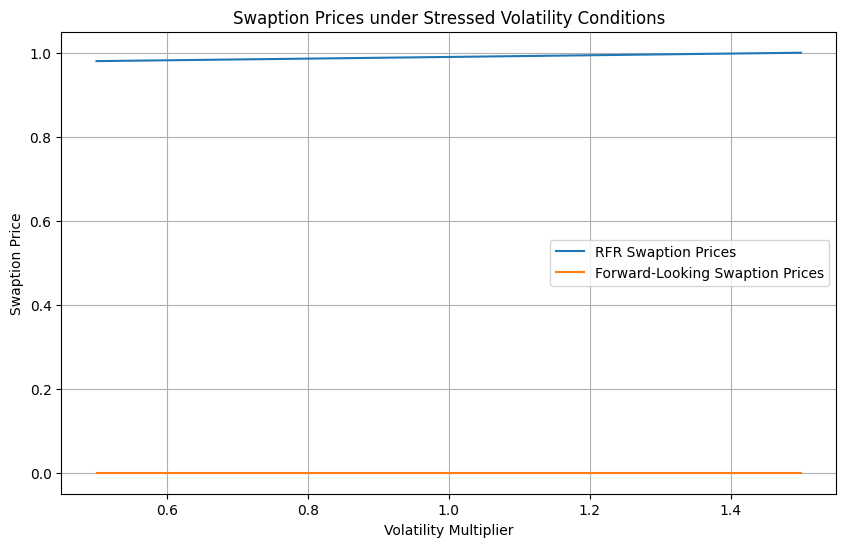

In [85]:
def run_stressed_volatility_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry):
    vol_multipliers = np.linspace(0.5, 1.5, 11)  # From -50% to +50% bumps
    rfr_prices = []
    forward_looking_prices = []

    for vol_multiplier in vol_multipliers:
        rfr_price = monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier)
        forward_price = monte_carlo_forward_looking_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, vol_multiplier)
        rfr_prices.append(rfr_price)
        forward_looking_prices.append(forward_price)
    
    return vol_multipliers, rfr_prices, forward_looking_prices

# Example parameters (these would be fetched or computed from market data in a real implementation)
T = 1.0  # 1 year
n_sims = 1000
dt = 1/252  # Daily steps
forward_rates = np.random.normal(0.02, 0.001, int(T / dt))  # Simplified example forward rates
discount_factors = np.exp(-0.02 * np.arange(0, T, dt))  # Simplified example discount factors
strike = 0.02  # Example strike rate
expiry = 0.5  # 6 months

vol_multipliers, rfr_prices, forward_looking_prices = run_stressed_volatility_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vol_multipliers, rfr_prices, label='RFR Swaption Prices')
plt.plot(vol_multipliers, forward_looking_prices, label='Forward-Looking Swaption Prices')
plt.xlabel('Volatility Multiplier')
plt.ylabel('Swaption Price')
plt.title('Swaption Prices under Stressed Volatility Conditions')
plt.legend()
plt.grid(True)
plt.show()


In [86]:
def run_fallback_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, isda_spread, accrual_period):
    extended_lmm = ExtendedLMM("swaption_vol_matrix.csv", "swap_curve.csv", (0.01, 0.02, 0.03), dt, 2)

    # Simulate and price using fallback methodology
    fallback_price = extended_lmm.price_legacy_deal_with_fallback(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, isda_spread, accrual_period)
    
    # Simulate and price using compounded RFR rate plus ISDA spread
    compounded_rfr_rate = extended_lmm.calculate_compounded_rfr(forward_rates, accrual_period)
    adjusted_rate = compounded_rfr_rate + isda_spread
    rfr_price = monte_carlo_rfr_swaption_pricing(T, n_sims, dt, forward_rates, discount_factors, adjusted_rate, expiry)

    print(f"Fallback Price: {fallback_price}")
    print(f"Compounded RFR Price: {rfr_price}")

    return fallback_price, rfr_price

# Example parameters (these would be fetched or computed from market data in a real implementation)
T = 1.0  # 1 year
n_sims = 1000
dt = 1/252  # Daily steps
forward_rates = np.random.normal(0.02, 0.001, int(T / dt))  # Simplified example forward rates
discount_factors = np.exp(-0.02 * np.arange(0, T, dt))  # Simplified example discount factors
strike = 0.02  # Example strike rate
expiry = 0.5  # 6 months
isda_spread = 0.002616  # Example ISDA spread for USD Libor 3M
accrual_period = 0.25  # Example accrual period for 3M

run_fallback_comparisons(T, n_sims, dt, forward_rates, discount_factors, strike, expiry, isda_spread, accrual_period)


TypeError: LMM() takes no arguments